In [1]:
#IMPORTS#############################################################
import requests
import visualisationGlock2 as v
import json
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm, trange
#VARIABLES###########################################################
# URLS
urlo = "https://entersim.bloctave.fr/"
teamName = "T1"
url = f'https://entersim.bloctave.fr/control/poll/create_from_example_sim4/{teamName}'

sampleUrl = "https://entersim2.bloctave.fr/enterprise/poll/inventory"

# MISC
nbSteps = 232 #hours

#FUNCTIONS##########################################################
def runOneStep() :
    requests.post( urlo+ "control/poll/run_one_step")

def getPoll(url) :
    return requests.get(urlo + "enterprise/poll/"+url)

def init(runstep=True):
    response = requests.post(url)
    print(response)
    if runstep :
        runOneStep()


In [2]:
#SPECIFIC FUNCTIONS###########################################
# FUND
def createFundGraph(ax):
    return v.LineGraph("", x_legend='Hours', y_legend="Funds in euro",ax=ax)

def getFunds():
    response = getPoll('inventory').json()
    return response['funds_in_eur']

# PROFIT
def createProfitGraph(ax):
    return v.LineGraph("", x_legend='Hours', y_legend="Profit in euro",ax=ax)

# ITEMS
def createItemsGraph(ax):
    return v.MultipleLineGraph(["ProcMat1 break-even price","ProcMat1 sale price","ProcMat2 break-even price","ProcMat2 sale price"],title="",x_legend="Hours",y_legend="Price (Euro)",ax=ax)

def getItems():
    response_market = getPoll('market_price').json()

    price1 = [i['unit_price'] for i in response_market if i['item']['name']=='ProcMat1']
    price2 = [i['unit_price'] for i in response_market if i['item']['name']=='ProcMat2']


    response_accounting = getPoll('analytical_accounting_sim4').json()

    breakeven1 = response_accounting['ProcMat1']
    breakeven2 = response_accounting['ProcMat2']

    return [breakeven1,price1,breakeven2,price2]


<Response [201]>


  0%|          | 0/232 [00:00<?, ?it/s]

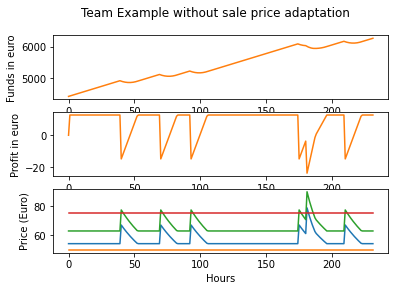

In [3]:
#Initialisation
init()

#Composite plot
fig, axs = plt.subplots(3)
fig.suptitle('Team Example without sale price adaptation')

graphs = []

# Initialisation
funds = createFundGraph(axs[0])
profits = createProfitGraph(axs[1])
items = createItemsGraph(axs[2])

graphs.extend([funds,profits,items])

#Usefull variables
prevFunds = None

for i in tqdm(range(nbSteps)) :
    #1.FUNDS
    currFunds = getFunds()
    funds.addPoint(i,currFunds)
    #2.PROFIT
    if prevFunds==None :prevFunds=currFunds
    profit = currFunds-prevFunds
    profits.addPoint(i,profit)
    prevFunds=currFunds
    #3.SALE PRICE
    items.addPoint(i,getItems())

    #Run one step
    runOneStep()

# Display it
for graph in graphs :
    graph.refreshDisplay()


If the only factor affecting the total profit is the fact that machine can partially break down and produce less, by reading the graph above we can clearly see that it directly impacts the profit per hour and the funds of the company. To balance these irregularities a solution could be to adapt the price of the products whenever the machine breaks down, it would result to a constant profit per hour, as it is compensated by the price of the products and the funds would grow following a more steady affine law.

In [ ]:
#Initialisation
init()

#Composite plot
fig, axs = plt.subplots(3)
fig.suptitle('Team Example with sale price adaptation')

graphs = []

# Initialisation
funds = createFundGraph(axs[0])
profits = createProfitGraph(axs[1])
items = createItemsGraph(axs[2])

graphs.extend([funds,profits,items])

#Usefull variables
prevFunds = None

for i in tqdm(range(nbSteps)) :
    #1.FUNDS
    currFunds = getFunds()
    funds.addPoint(i,currFunds)
    #2.PROFIT
    if prevFunds==None :prevFunds=currFunds
    profit = currFunds-prevFunds
    profits.addPoint(i,profit)
    prevFunds=currFunds
    #3.SALE PRICE
    items.addPoint(i,getItems())

    response_accounting = getPoll('analytical_accounting_sim4').json()

    breakeven1 = response_accounting['ProcMat1']
    breakeven2 = response_accounting['ProcMat2']

    data = {
    'ProcMat1_unit_price': breakeven1,
    'ProcMat2_unit_price': breakeven2
    }

    response = requests.post(urlo + "enterprise/poll/set_market_sell_price_sim4", json=data)

    #Run one step
    runOneStep()

# Display it
for graph in graphs :
    graph.refreshDisplay()